In [13]:
import os
import math
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as tm
import torchvision.transforms.functional as tf
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import transformers
%matplotlib inline
sys.path.append('../code')
sys.path.append('../../nn_tools/')

from core.data_utils import read_dcms, get_spacing, read_annotation, SPINAL_DISC_ID, SPINAL_VERTEBRA_ID, rotate_point
from core.visilization import visilize_annotation, visilize_distmap, visilize_coord
from core.key_point import KeyPointAcc, KeyPointDataLoader, NullLoss, SpinalModelBase, KeyPointModel, KeyPointModelV2
from core.key_point import KeyPointBCELossV2, SpinalModel, KeyPointBCELoss, distance_distribution
from nn_tools import torch_utils

In [2]:
train_images, train_metainfos = read_dcms('../data/lumbar_train150/')
valid_images, valid_metainfos = read_dcms('../data/train/')

train_spacings = get_spacing(train_metainfos)
valid_spacings = get_spacing(valid_metainfos)

100%|##########| 2826/2826 [00:11<00:00, 238.17it/s]


In [3]:
train_annotation = read_annotation('../data/lumbar_train150_annotation.json')
valid_annotation = read_annotation('../data/lumbar_train51_annotation.json')
valid_annotation = {k: v for k, v in valid_annotation.items() if k in valid_images}

{'T11-T12': 1}


In [4]:
# all_pixels = [tf.to_tensor(image).flatten() for image in train_images.values()]
# all_pixels = torch.cat(all_pixels, dim=0)
# torch.save(all_pixels, 'all_pixels')

In [5]:
# all_pixels = torch.load('all_pixels')
# all_pixels = torch.cat([-all_pixels, all_pixels], dim=0)
# all_pixels.std()

In [14]:
train_pk_dataloader = KeyPointDataLoader(
    train_images, train_spacings, train_annotation, batch_size=8, num_workers=3,
    prob_rotate=1, max_angel=180, num_rep=20, prob_reverse=0, size=[512, 512],
    pin_memory=False
)
valid_pk_dataloader = KeyPointDataLoader(
    valid_images, valid_spacings, valid_annotation, batch_size=1, num_workers=3,
    prob_rotate=0, max_angel=45, num_rep=100, prob_reverse=0, size=[512, 512],
    pin_memory=False
)
generator = iter(valid_pk_dataloader)

100%|##########| 50/50 [00:00<00:00, 26372.64it/s]


In [7]:
# kp_model = torch.load('../models/size512_rotate1_180_AdamW_1e-5.kp_model', map_location='cuda:0')
# kp_model.set_spinal_model(SpinalModelBase())
backbone = resnet_fpn_backbone('resnet50', True)
spinal_model = SpinalModel(train_images, train_annotation,
                           num_candidates=128, num_selected_templates=8,
                           max_translation=0.05, scale_range=[0.9, 1.1], max_angel=10)
kp_model = KeyPointModelV2(backbone, len(SPINAL_VERTEBRA_ID), len(SPINAL_DISC_ID),
                         pixel_mean=torch.tensor(0.5), pixel_std=torch.tensor(1), dropout=0,
                         loss=KeyPointBCELossV2(lamb=1), spinal_model=spinal_model, loss_scaler=100,
                           num_cascades=2
                          ).cuda(0)
temp = torch.load('../models/size512_rotate1_180_AdamW_1e-5.kp_model', map_location='cuda:0')
kp_model.backbone.load_state_dict(temp.backbone.state_dict())
kp_model.fc.load_state_dict(temp.fc.state_dict())
# kp_model = torch.nn.DataParallel(kp_model, device_ids=[0, 1])

../code/core/key_point/model.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('pixel_mean', torch.tensor(pixel_mean))
../code/core/key_point/model.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('pixel_std', torch.tensor(pixel_std))


<All keys matched successfully>

In [8]:
# dir_path = '../models/'
# for model_name in os.listdir(dir_path):
#     if 'kp_model' in model_name:
#         model_name = os.path.join(dir_path, model_name)
#         temp = torch.load(model_name)
#         kp_model.load_state_dict(temp.state_dict())
#         torch.save(kp_model.cpu(), model_name)
#         del temp

In [9]:
# with torch.no_grad():
#     batch = next(generator)
#     temp.train()
#     loss = temp(*batch[0])
#     print(loss)
#     kp_model.train()
#     print(kp_model(*batch[0]))
#     print(torch_utils.evaluate(kp_model, valid_pk_dataloader, [KeyPointAcc(8)]))

In [10]:
optimizer = torch.optim.AdamW(kp_model.parameters(), lr=1e-5)
max_step = 50*len(train_pk_dataloader)
result = torch_utils.fit(
    kp_model,
    train_pk_dataloader,
    valid_pk_dataloader,
    optimizer,
    max_step,
    NullLoss(),
    [KeyPointAcc(6)],
    is_higher_better=True,
    evaluate_per_steps=len(train_pk_dataloader),
#     scheduler=scheduler,
#     checkpoint_dir='../models',
    early_stopping=5*len(train_pk_dataloader),
)

using NullLoss as training loss, using KeyPointAcc(higher is better) as early stopping metric


100%|##########| 1000/1000 [00:32<00:00, 30.51it/s]


step 375 train NullLoss: 0.30023840069770813
valid KeyPointAcc: 0.535727322101593


100%|##########| 1000/1000 [00:32<00:00, 30.46it/s]


step 750 train NullLoss: 0.08934228867292404
valid KeyPointAcc: 0.5933636426925659


100%|##########| 1000/1000 [00:32<00:00, 30.56it/s]


step 1125 train NullLoss: 0.07160323113203049
valid KeyPointAcc: 0.6321819424629211


100%|##########| 1000/1000 [00:32<00:00, 30.60it/s]


step 1500 train NullLoss: 0.06617479026317596
valid KeyPointAcc: 0.6877272129058838


100%|##########| 1000/1000 [00:32<00:00, 30.38it/s]


step 1875 train NullLoss: 0.06020128354430199
valid KeyPointAcc: 0.720090925693512


100%|##########| 1000/1000 [00:32<00:00, 30.48it/s]


step 2250 train NullLoss: 0.05304740369319916
valid KeyPointAcc: 0.7431818246841431


100%|##########| 1000/1000 [00:32<00:00, 30.53it/s]


step 2625 train NullLoss: 0.050450026988983154
valid KeyPointAcc: 0.7090910077095032


100%|##########| 1000/1000 [00:32<00:00, 30.89it/s]


step 3000 train NullLoss: 0.05133911594748497
valid KeyPointAcc: 0.7480001449584961


100%|##########| 1000/1000 [00:32<00:00, 30.88it/s]


step 3375 train NullLoss: 0.049025580286979675
valid KeyPointAcc: 0.7382727265357971


100%|##########| 1000/1000 [00:32<00:00, 30.63it/s]


step 3750 train NullLoss: 0.051777906715869904
valid KeyPointAcc: 0.7556363940238953


100%|##########| 1000/1000 [00:32<00:00, 30.70it/s]


step 4125 train NullLoss: 0.05746270343661308
valid KeyPointAcc: 0.770545482635498


100%|##########| 1000/1000 [00:32<00:00, 30.43it/s]


step 4500 train NullLoss: 0.04863910377025604
valid KeyPointAcc: 0.7758182287216187


100%|##########| 1000/1000 [00:32<00:00, 30.50it/s]


step 4875 train NullLoss: 0.04512600228190422
valid KeyPointAcc: 0.7925453782081604


100%|##########| 1000/1000 [00:33<00:00, 29.92it/s]


step 5250 train NullLoss: 0.044092047959566116
valid KeyPointAcc: 0.770545482635498


100%|##########| 1000/1000 [00:32<00:00, 30.39it/s]


step 5625 train NullLoss: 0.04629746079444885
valid KeyPointAcc: 0.7903636693954468


100%|##########| 1000/1000 [00:32<00:00, 30.55it/s]


step 6000 train NullLoss: 0.04397740215063095
valid KeyPointAcc: 0.80472731590271


100%|##########| 1000/1000 [00:32<00:00, 30.73it/s]


step 6375 train NullLoss: 0.04433312639594078
valid KeyPointAcc: 0.7586362957954407


100%|##########| 1000/1000 [00:32<00:00, 30.73it/s]


step 6750 train NullLoss: 0.05137695372104645
valid KeyPointAcc: 0.8314546346664429


100%|##########| 1000/1000 [00:32<00:00, 30.60it/s]


step 7125 train NullLoss: 0.038399405777454376
valid KeyPointAcc: 0.8264545798301697


100%|##########| 1000/1000 [00:33<00:00, 30.18it/s]


step 7500 train NullLoss: 0.04390057921409607
valid KeyPointAcc: 0.8105455040931702


100%|##########| 1000/1000 [00:30<00:00, 32.32it/s]


step 7875 train NullLoss: 0.037095241248607635
valid KeyPointAcc: 0.828000009059906


100%|##########| 1000/1000 [00:25<00:00, 38.93it/s]


step 8250 train NullLoss: 0.037404872477054596
valid KeyPointAcc: 0.848454475402832


100%|##########| 1000/1000 [00:33<00:00, 29.80it/s]


step 8625 train NullLoss: 0.037972744554281235
valid KeyPointAcc: 0.7978182435035706


100%|##########| 1000/1000 [00:32<00:00, 30.32it/s]


step 9000 train NullLoss: 0.04078035056591034
valid KeyPointAcc: 0.8299999833106995


100%|##########| 1000/1000 [00:33<00:00, 30.28it/s]


step 9375 train NullLoss: 0.038883887231349945
valid KeyPointAcc: 0.8258181810379028


100%|##########| 1000/1000 [00:33<00:00, 30.25it/s]


step 9750 train NullLoss: 0.04041164740920067
valid KeyPointAcc: 0.8388181924819946


100%|##########| 1000/1000 [00:33<00:00, 29.79it/s]


step 10125 train NullLoss: 0.036985427141189575
valid KeyPointAcc: 0.8590909242630005


100%|##########| 1000/1000 [00:25<00:00, 39.21it/s]


step 10500 train NullLoss: 0.03419710323214531
valid KeyPointAcc: 0.8269999027252197


100%|##########| 1000/1000 [00:25<00:00, 38.70it/s]


step 10875 train NullLoss: 0.036212578415870667
valid KeyPointAcc: 0.8658182621002197


100%|##########| 1000/1000 [00:25<00:00, 38.95it/s]


step 11250 train NullLoss: 0.041536543518304825
valid KeyPointAcc: 0.839545488357544


100%|##########| 1000/1000 [00:25<00:00, 38.90it/s]


step 11625 train NullLoss: 0.033923931419849396
valid KeyPointAcc: 0.8137272596359253


100%|##########| 1000/1000 [00:25<00:00, 39.34it/s]


step 12000 train NullLoss: 0.03368709981441498
valid KeyPointAcc: 0.8583636283874512


100%|##########| 1000/1000 [00:25<00:00, 39.53it/s]


step 12375 train NullLoss: 0.03596081957221031
valid KeyPointAcc: 0.8391817808151245


100%|##########| 1000/1000 [00:25<00:00, 39.26it/s]


step 12750 train NullLoss: 0.03856742009520531
valid KeyPointAcc: 0.8276364207267761


In [19]:
# torch_utils.evaluate(temp, valid_pk_dataloader, [KeyPointAcc(6)])

In [ ]:
dists = distance_distribution(temp.cuda(0), valid_pk_dataloader)
plt.hist(dists.cpu(), bins=list(range(40)))

In [16]:
torch_utils.evaluate(kp_model, valid_pk_dataloader, [KeyPointAcc(6)])

100%|##########| 5000/5000 [02:06<00:00, 39.55it/s]


[('KeyPointAcc', tensor(0.8602))]

100%|##########| 5000/5000 [02:07<00:00, 39.36it/s]


(array([4.3980e+03, 1.0299e+04, 1.1927e+04, 9.6440e+03, 6.8270e+03,
        4.1810e+03, 2.5040e+03, 1.6120e+03, 1.0180e+03, 5.8200e+02,
        4.0400e+02, 2.5400e+02, 1.7000e+02, 1.2100e+02, 1.1500e+02,
        8.7000e+01, 8.2000e+01, 3.5000e+01, 3.7000e+01, 3.8000e+01,
        3.3000e+01, 2.7000e+01, 3.0000e+01, 2.8000e+01, 1.9000e+01,
        2.5000e+01, 3.4000e+01, 3.5000e+01, 4.4000e+01, 5.6000e+01,
        7.4000e+01, 9.8000e+01, 6.0000e+01, 3.3000e+01, 2.1000e+01,
        1.1000e+01, 7.0000e+00, 9.0000e+00, 4.0000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 <a list of 39 Patch objects>)

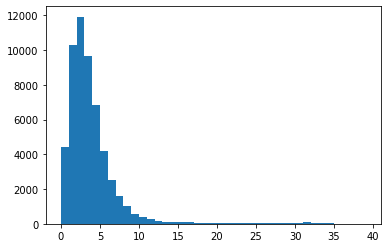

In [18]:
dists = distance_distribution(kp_model, valid_pk_dataloader)
plt.hist(dists.cpu(), bins=list(range(40)))

In [20]:
torch.save(kp_model, '../models/20200702.kp_model_v2')

In [ ]:
# kp_model = torch.load('../models/resize_rotate_reverse.kp_model')
# test_pk_dataloader = KeyPointDataLoader(
#     valid_images, valid_spacings, valid_annotation, batch_size=1,
#     random_resize=True, prob_rotate=1, max_angel=45,
# )
# generator = iter(test_pk_dataloader)
# torch_utils.evaluate(kp_model, test_pk_dataloader, [KeyPointAcc()])

In [ ]:
# batch_data, batch_label = next(generator)
# with torch.no_grad():
#     kp_model.eval()
#     vertebra_coords, disc_coords, heat_maps, feature_maps = kp_model(*batch_data, return_more=True)
# #     print(KeyPointAcc()(preds, *batch[1]))
# visilize_coord(tf.to_pil_image(batch_data[0][0]), vertebra_coords[0])

In [ ]:
# tf.to_pil_image(1 / (batch[1][0][0, 7] / 8 * math.log(2)).exp())

In [ ]:
# tf.to_pil_image(heat_maps[0, 4].cpu())